In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo VirusSample.csv en un DataFrame llamado "db"
db = pd.read_csv('VirusSample.csv')

# Imprimir un resumen de los datos
print(db.describe())

                                            file                          api  \
count                                       9795                         9795   
unique                                      9795                         2980   
top     7ff49f2f0912352416b05c010f35f402cc79feed  LoadLibraryA,GetProcAddress   
freq                                           1                         1007   

         class  
count     9795  
unique      13  
top     Trojan  
freq      6153  


In [2]:
print(db.head(5))

                                       file  \
0  7ff49f2f0912352416b05c010f35f402cc79feed   
1  50cc6c99ec285d0db45dde07d8fdc18d9098c5b6   
2  f77c6bd4aebacd1a01d02e0cb20642ebf2d32929   
3  349c367c5b88fbb6cafae5d7109588d7250e16b5   
4  021f4aa86b520e1d606ab26699c35546bcd00c27   

                                                 api  class  
0         IntersectRect,GetCurrentProcess,GetVersion  Virus  
1  GetCaretBlinkTime,CountClipboardFormats,GetCon...  Virus  
2  VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...  Virus  
3  SetTraceCallback,CopyAcceleratorTableW,GetProc...  Virus  
4  SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...  Virus  


In [3]:
tabla = db['class'].value_counts()
print(tabla)

Trojan        6153
Virus         2367
Backdoor       447
Worms          441
Adware         222
Agent          102
Downloader      31
Spyware         11
Ransomware      10
Riskware         4
Dropper          4
Crypt            2
Keylogger        1
Name: class, dtype: int64


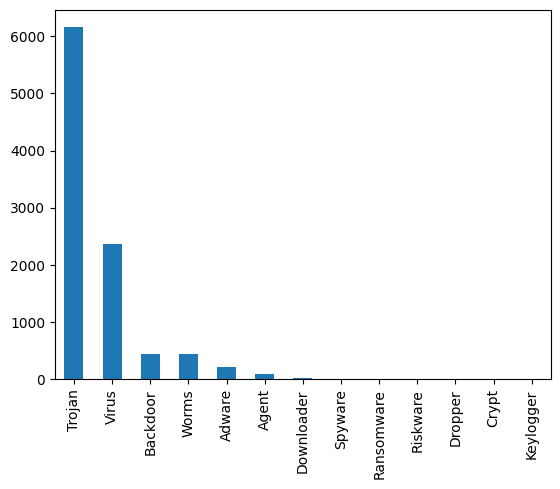

In [4]:
tabla = db['class'].value_counts()
tabla.plot.bar()
plt.show()

Se puede observar que los distintos tipos de virus no se distribuyen de manera equilibrada en el conjunto de datos. A pesar de ello, si los reequilibráramos, asegurándonos de tener al menos una instancia de cada tipo de virus en cada categoría, continuaríamos trabajando con estos datos desbalanceados.

Además, podemos identificar cuáles son las APIS más frecuentes en el conjunto de datos:

In [5]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Quezada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Reemplazar las comas en la columna "api" con espacios
db['api'] = db['api'].apply(lambda x: re.sub(',', ' ', x))

# Crear una lista de las palabras en la columna "api"
words_list = db['api'].str.lower().str.split().tolist()

# Remover las palabras vacías de la lista
stop_words = set(stopwords.words('english'))
words_list = [[word for word in words if word not in stop_words] for words in words_list]

# Crear una matriz de términos-documentos
vectorizer = CountVectorizer()
dtm_m = vectorizer.fit_transform([' '.join(words) for words in words_list]).toarray()

# Obtener una lista de los términos
terms = vectorizer.vocabulary_.keys()

# Calcular la frecuencia de los términos
freqs = dtm_m.sum(axis=0)

# Crear un DataFrame con los términos y su frecuencia
dtm_d = pd.DataFrame({'word':terms, 'freq':freqs}).sort_values(by='freq', ascending=False)

# Mostrar los 10 términos más frecuentes
print(dtm_d.head(10))

                            word  freq
3363             setcommtimeouts  6066
4199             ntfscontrolfile  5130
2606             getmonitorinfoa  4882
3291     elfregistereventsourcew  3891
7587           mcigetcreatortask  2851
1752                    _getname  2836
7589              joygetdevcapsw  2763
3106          getmodulehandleexa  2425
7763               createactctxw  2338
5592  _zn8qmapdata10createdataei  2319


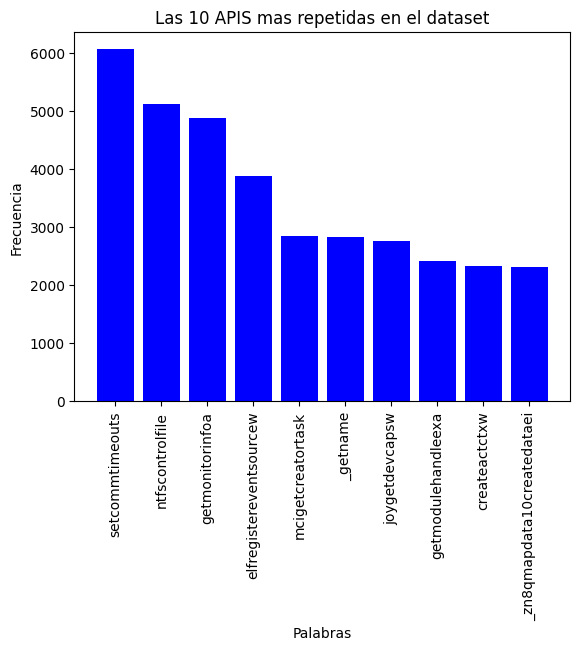

In [7]:
# Obtener las frecuencias de las 10 palabras más frecuentes
freqs = dtm_d.iloc[:10]['freq']

# Obtener los nombres de las 10 palabras más frecuentes
words = dtm_d.iloc[:10]['word']

# Crear el gráfico de barras
plt.bar(words, freqs, color="blue")

# Ajustar el texto de los nombres en el eje x
plt.xticks(rotation=90, ha='center')

# Agregar título y etiquetas de los ejes
plt.title("Las 10 APIS mas repetidas en el dataset")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Mostrar el gráfico
plt.show()

### Preprosesamiento
Como se mencionó previamente, los datos no están balanceados, por lo que se requiere realizar una balanceo. No obstante, algunas variables tienen muy pocos datos, por lo que se ha decidido unirlos en una sola categoría. Estas variables son Crypt, Downloader, Dropper, Keylogger, Ransomware, Riskware y Spyware.

## Implementacion


In [3]:
# SVM 
import pandas as pd
from sklearn import svm

# Lee los datos y convierte las columnas de class, file y api en factores
db = pd.read_csv('VirusSample.csv')
db['class'] = pd.factorize(db['class'])[0]
db['file'] = pd.factorize(db['file'])[0]
db['api'] = pd.factorize(db['api'])[0]

# Indica el porcentaje de entrenamiento
porcentaje = 0.7

# Divide los datos en conjunto de entrenamiento y prueba
corte = int(len(db.index) * porcentaje)
train = db[:corte]
test = db[corte:]

# Entrena el modelo SVM
X_train = train.drop('class', axis=1)
y_train = train['class']
modelosvm = svm.SVC(kernel='linear', C=1, gamma='auto')
modelosvm.fit(X_train, y_train)

# Muestra un resumen del modelo
print(modelosvm)


Realmente este codigo es funcional, pero cuenta con la limitante que resulta demasiado pesado para el procesamiento de Python, ya que la instruccion de: "len" se toma demasiado tiempo en analizar aproximadamente 10,000 rows. 

Y ahora para el modelo de Random Forest usamos: 

In [17]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Lee los datos y selecciona las columnas "api" y "class"
db = pd.read_csv('VirusSample.csv')
new_db = db[['api', 'class']].copy()

# Agrupa las categorías de api
new_db['new_api'] = pd.factorize(new_db['api'])[0]
new_db['new_api'] = np.where(new_db['new_api'] <= 50, new_db['api'], 'Otros')

# Muestra el resumen del nuevo dataframe
print(new_db.head(5))
print(new_db.describe())

# Indica el porcentaje de entrenamiento
porcentaje = 0.7

# Divide los datos en conjuntos de entrenamiento y prueba
corte2 = int(len(new_db.index) * porcentaje)
train2 = new_db[:corte2]
test2 = new_db[corte2:]

# Entrena el modelo Random Forest
X_train = train2[['new_api']]
y_train = train2['class']
modelo_rf = RandomForestClassifier(n_estimators=500)
modelo_rf.fit(X_train, y_train).astype()

# Muestra un resumen del modelo
print(modelo_rf)


                                                 api  class  \
0         IntersectRect,GetCurrentProcess,GetVersion  Virus   
1  GetCaretBlinkTime,CountClipboardFormats,GetCon...  Virus   
2  VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...  Virus   
3  SetTraceCallback,CopyAcceleratorTableW,GetProc...  Virus   
4  SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...  Virus   

                                             new_api  
0         IntersectRect,GetCurrentProcess,GetVersion  
1  GetCaretBlinkTime,CountClipboardFormats,GetCon...  
2  VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...  
3  SetTraceCallback,CopyAcceleratorTableW,GetProc...  
4  SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...  
                                api   class new_api
count                          9795    9795    9795
unique                         2980      13      52
top     LoadLibraryA,GetProcAddress  Trojan   Otros
freq                           1007    6153    9743


ValueError: could not convert string to float: 'IntersectRect,GetCurrentProcess,GetVersion'

Debido a que en Python por nuestros medios conocidos el tiempo de ejecucion de la lectura de los datos excedia las 4 horas y aun no presentaba la ejecucion, se opto por crear la implementacion de los modelos en con un lenguaje que soporte estos datos de manera mucho mas rapida, por eso se opto por crear un reporte en html mediante R. 